In [1]:
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.infogram import H2OInfogram
from h2o.estimators.gbm import H2OGradientBoostingEstimator
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, '..')
from DataModule.Data_Preparation import CoronnaCERTAINDataset
import EvaluationModule
pd.options.mode.chained_assignment = None

(CVXPY) Jul 20 05:57:11 PM: Encountered unexpected exception importing solver CVXOPT:
ImportError("dlopen(/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/cvxopt/base.cpython-310-darwin.so, 0x0002): tried: '/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/cvxopt/base.cpython-310-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64e'))")
(CVXPY) Jul 20 05:57:11 PM: Encountered unexpected exception importing solver GLPK:
ImportError("dlopen(/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/cvxopt/base.cpython-310-darwin.so, 0x0002): tried: '/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/cvxopt/base.cpython-310-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64e'))")
(CVXPY) Jul 20 05:57:11 PM: Encountered unexpected exception importing solver GLPK_MI:
ImportError("dlopen(/Users/gaskell/miniforge_x86_64/e

In [2]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [3]:
dataset = CoronnaCERTAINDataset(
    library_root = '/Users/gaskell/Dropbox/Mac/Desktop/Autoimmune_Disease/Code/ML_RA_EHR/Dataset/',
    challenge = 'binary_classification', #option: regression, regression_delta, classification, binary_classification, regression_delta_binary
    dataset = 'CORRONA CERTAIN', 
    process_approach = 'SC', #option: KVB, SC
    imputation = 'IterativeImputer', #option: SimpleFill, KNN, SoftImpute, BiScaler, NuclearNormMinimization, IterativeImputer, IterativeSVD, None(raw)
    patient_group = 'bionaive TNF', #option: "all", "bioexp nTNF", "bionaive TNF", "bionaive orencia", "KVB"
    drug_group = 'all', #option: "all", "actemra", "cimzia", "enbrel", "humira", "orencia", "remicade", "rituxan", "simponi"
    time_points = (0,3), 
    train_test_rate = 0.6,
    remove_low_DAS = False,
    save_csv = False, 
    random_state = 2022,
    verbose=False)

In [4]:
train, train_loc = dataset.get_train()
test, test_loc = dataset.get_test()

In [5]:
train.head(10)

,grp,init_group,age,gender,final_education,race_grp,ethnicity,weight,BMI,height,...,md_global_assess,pt_global_assess,di,pt_pain,usresultsCRP,usresultsIgA,usresultsIgG,usresultsIgM,DAS28_CRP_0M,DrugResponse_binary
0,1,0,54.0,1,0,7,1,225.0,31.377703,71.0,...,50.0,25.0,0.285714,25.0,1.640000,144.0,886.0,113.0,3.189429,1.0
1,1,0,54.0,0,0,7,1,175.0,28.242654,66.0,...,35.0,17.0,0.250000,25.0,1.190000,207.0,1010.0,56.0,2.935127,0.0
2,1,0,61.0,0,0,7,1,240.0,39.933728,65.0,...,55.0,50.0,0.250000,60.0,1.000000,44.0,948.0,51.0,3.719481,0.0
3,1,0,64.0,1,0,7,1,294.0,41.000198,71.0,...,55.0,55.0,0.285714,70.0,16.740000,178.0,882.0,87.0,5.146565,1.0
4,2,0,51.0,0,2,7,1,90.0,18.175812,59.0,...,65.0,20.0,0.250000,65.0,0.250000,155.0,824.0,43.0,4.425214,1.0
5,3,0,57.0,0,0,7,1,161.0,30.417361,61.0,...,70.0,55.0,1.000000,65.0,9.705087,273.0,714.0,138.0,5.103459,1.0
6,2,0,62.0,0,0,7,1,150.0,26.568405,63.0,...,50.0,25.0,0.000000,20.0,17.930000,171.0,992.0,95.0,5.278515,1.0
7,1,0,54.0,1,2,7,1,182.0,25.381075,71.0,...,40.0,10.0,0.142857,5.0,4.700000,267.0,1110.0,109.0,3.604865,1.0
8,1,0,50.0,0,0,7,1,250.0,39.151259,67.0,...,35.0,27.0,0.500000,20.0,1.330000,402.0,1290.0,89.0,3.809990,0.0
9,2,0,54.0,1,0,7,1,178.0,28.726814,66.0,...,40.0,10.0,0.000000,25.0,0.620000,213.0,1050.0,83.0,2.878648,1.0


In [6]:
# Start the H2O cluster (locally)
h2o.init()

# Import a sample binary outcome train/test set into H2O
train_h2o = h2o.upload_file(str(train_loc))
test_h2o = h2o.upload_file(str(test_loc))

# Identify predictors and response
x = train_h2o.columns[:-1]
# y = "DAS28_CRP_3M"
y = "DrugResponse_binary"

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "13.0.2" 2020-01-14; Java(TM) SE Runtime Environment (build 13.0.2+8); Java HotSpot(TM) 64-Bit Server VM (build 13.0.2+8, mixed mode, sharing)
  Starting server from /Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/c9/_bb79xy945g7bvvn1rl6zsfr0000gn/T/tmpy6zw90k_
  JVM stdout: /var/folders/c9/_bb79xy945g7bvvn1rl6zsfr0000gn/T/tmpy6zw90k_/h2o_gaskell_started_from_python.out
  JVM stderr: /var/folders/c9/_bb79xy945g7bvvn1rl6zsfr0000gn/T/tmpy6zw90k_/h2o_gaskell_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,10 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.2
H2O_cluster_version_age:,1 month and 24 days
H2O_cluster_name:,H2O_from_python_gaskell_b9rz0r
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [7]:
train_h2o

grp,init_group,age,gender,final_education,race_grp,ethnicity,weight,BMI,height,newsmoker,drinker,drinksperwk,duration_ra,ara_func_class,num_tnf,num_nontnf,ndmardused,rfstatus_b,usresultsRF,ccpstatus_b,usresultsCCP3,hxmi,hxunstab_ang,hxchf,hxother_cv,hxtia,hxstroke,hxcopd,hxhtn,hxdiabetes,hxhld,hx_anycancer,seatedbp1,seatedbp2,pres_mtx,pres_arava,pres_azulfidine,pres_plaquenil,pres_imuran,pres_minocin,pres_pred,nonpresNSAIDs_use,NSAIDs_use,tender_jts_28,swollen_jts_28,md_global_assess,pt_global_assess,di,pt_pain,usresultsCRP,usresultsIgA,usresultsIgG,usresultsIgM,DAS28_CRP_0M,DrugResponse_binary
1,0,54,1,0,7,1,225,31.3777,71,3,2,0.7,7,0,0,0,2,1,56.4,0,15,0,0,0,0,0,0,0,0,0,0,0,122,88,0,0,0,1,0,0,0,0,1,3,4,50,25,0.285714,25,1.64,144,886,113,3.18943,1
1,0,54,0,0,7,1,175,28.2427,66,3,2,2,2,0,0,0,1,1,16.8,0,15,0,0,0,0,0,0,0,0,0,0,0,108,69,0,0,0,0,0,0,0,0,0,3,3,35,17,0.25,25,1.19,207,1010,56,2.93513,0
1,0,61,0,0,7,1,240,39.9337,65,2,2,0.466667,1,0,0,0,1,0,9.8,0,15,0,0,0,0,0,0,0,0,1,0,0,110,80,1,0,0,0,0,0,1,0,0,3,9,55,50,0.25,60,1,44,948,51,3.71948,0
1,0,64,1,0,7,1,294,41.0002,71,2,2,2,2,1,0,0,1,0,8.7,0,15,0,0,0,0,0,0,0,0,0,0,0,137,87,1,0,0,0,0,0,0,0,1,6,13,55,55,0.285714,70,16.74,178,882,87,5.14656,1
2,0,51,0,2,7,1,90,18.1758,59,0,1,0,5,1,0,0,1,1,30.5,1,174,0,0,0,0,0,0,0,0,0,0,0,100,70,1,0,0,0,0,0,1,0,0,14,13,65,20,0.25,65,0.25,155,824,43,4.42521,1
3,0,57,0,0,7,1,161,30.4174,61,3,1,0,3,1,0,0,1,1,110.2,1,251,0,0,0,0,0,0,0,1,0,1,0,132,79,1,0,0,0,0,0,1,0,0,9,9,70,55,1,65,9.70509,273,714,138,5.10346,1
2,0,62,0,0,7,1,150,26.5684,63,2,2,14,2,1,0,0,1,0,9.4,0,15,0,0,0,0,0,0,0,1,0,0,0,112,75,1,0,0,0,0,0,0,0,0,12,12,50,25,0,20,17.93,171,992,95,5.27851,1
1,0,54,1,2,7,1,182,25.3811,71,0,2,0.466667,2,0,0,0,1,1,750,1,251,0,0,0,0,0,0,0,0,0,0,0,119,76,1,0,0,0,0,0,0,0,0,5,5,40,10,0.142857,5,4.7,267,1110,109,3.60486,1
1,0,50,0,0,7,1,250,39.1513,67,2,2,0.466667,0,1,0,0,1,1,92.4,1,73,0,0,0,0,0,0,0,0,0,0,0,110,80,0,0,0,0,0,0,0,0,0,7,6,35,27,0.5,20,1.33,402,1290,89,3.80999,0
2,0,54,1,0,7,1,178,28.7268,66,2,2,14,0,0,0,0,0,0,7.8,0,15,0,0,0,0,0,0,0,0,0,0,0,120,76,0,0,0,0,0,0,0,0,1,4,3,40,10,0,25,0.62,213,1050,83,2.87865,1


In [8]:
for feature in dataset.categorical:
    train_h2o[feature] = train_h2o[feature].asfactor()
    test_h2o[feature] = test_h2o[feature].asfactor()
train_h2o[y] = train_h2o[y].asfactor()
test_h2o[y] = test_h2o[y].asfactor()

In [9]:
# Run AutoML for 20 base models
aml = H2OAutoML(max_runtime_secs = 60, seed = 1, project_name = "SC_classification_Jul20")
aml.train(x=x, y=y, training_frame=train_h2o, leaderboard_frame = test_h2o)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

AutoML progress: |
17:57:35.256: _train param, Dropping bad and constant columns: [pres_imuran, pres_minocin, init_group, num_tnf, num_nontnf]

██
17:57:38.878: _train param, Dropping bad and constant columns: [pres_imuran, pres_minocin, init_group, num_tnf, num_nontnf]

█
17:57:40.684: _train param, Dropping bad and constant columns: [pres_imuran, pres_minocin, init_group, num_tnf, num_nontnf]

█
17:57:40.887: GBM_1_AutoML_1_20220720_175735 [GBM def_5] failed: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_1_AutoML_1_20220720_175735.  Details: ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 188.0.
ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 188.0.
ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
DeepLearning_grid_1_AutoML_1_20220720_175735_model_1,0.662167,0.70809,0.79773,0.393417,0.44549,0.198461
GBM_grid_1_AutoML_1_20220720_175735_model_13,0.658833,0.590738,0.799075,0.392583,0.436446,0.190485
StackedEnsemble_BestOfFamily_4_AutoML_1_20220720_175735,0.650833,0.571619,0.79988,0.403,0.436212,0.190281
DeepLearning_1_AutoML_1_20220720_175735,0.6475,0.716922,0.777064,0.4455,0.458063,0.209821
DRF_1_AutoML_1_20220720_175735,0.637667,0.580608,0.808159,0.489583,0.440749,0.19426
StackedEnsemble_BestOfFamily_2_AutoML_1_20220720_175735,0.636167,0.584705,0.803553,0.413417,0.442753,0.19603
GBM_grid_1_AutoML_1_20220720_175735_model_15,0.634833,0.610027,0.772339,0.431083,0.442056,0.195413
GBM_grid_1_AutoML_1_20220720_175735_model_3,0.634833,0.58148,0.811432,0.388583,0.440437,0.193985
StackedEnsemble_BestOfFamily_3_AutoML_1_20220720_175735,0.634,0.586314,0.796425,0.489583,0.443237,0.196459
DeepLearning_grid_3_AutoML_1_20220720_175735_model_2,0.621167,0.589716,0.771285,0.4415,0.441086,0.194556


In [10]:
lb['model_id']

model_id
DeepLearning_grid_1_AutoML_1_20220720_175735_model_1
GBM_grid_1_AutoML_1_20220720_175735_model_13
StackedEnsemble_BestOfFamily_4_AutoML_1_20220720_175735
DeepLearning_1_AutoML_1_20220720_175735
DRF_1_AutoML_1_20220720_175735
StackedEnsemble_BestOfFamily_2_AutoML_1_20220720_175735
GBM_grid_1_AutoML_1_20220720_175735_model_15
GBM_grid_1_AutoML_1_20220720_175735_model_3
StackedEnsemble_BestOfFamily_3_AutoML_1_20220720_175735
DeepLearning_grid_3_AutoML_1_20220720_175735_model_2


In [11]:
# aml_sc = EvaluationModule.AutoBuild(seed=1, project_name="EHR_RA_SC", challenge=dataset.challenge)
# test, test_loc = dataset.get_test()

# for model in lb.as_data_frame()['model_id']:
#     m = h2o.get_model(model)
#     pred = m.predict(test_h2o).as_data_frame()
#     aml_sc.evaluate(model, test, pred)

In [12]:
# aml_sc = evaluate.AutoBuild(seed=1, project_name="EHR_RA_SC")
# test, test_loc = dataset.get_test()
# baseline = test['DAS28_CRP_0M']
# true = test['DAS28_CRP_3M']

In [13]:
# pred = pred.as_data_frame()

In [14]:
# aml_sc.evaluate("stackedensemble", test, pred)

In [17]:
# classification.sort_values('Accuracy',ascending=False)

In [18]:
# gbm = H2OGradientBoostingEstimator(nfolds = 5, seed = 1)
# gbm.train(x=x, y=y, training_frame=train_h2o)

In [19]:
# gbm.auc(xval=True)

In [23]:
perf = aml.leader.model_performance(train_h2o)
perf


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.16137163175062896
RMSE: 0.40171088079690964
LogLoss: 0.6022117662942901
Mean Per-Class Error: 0.39276771956856704
AUC: 0.7713790446841293
AUCPR: 0.8918216912341242
Gini: 0.5427580893682586

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3155134675142367: 


,,0,1,Error,Rate
0,0,15.0,44.0,0.7458,(44.0/59.0)
1,1,7.0,169.0,0.0398,(7.0/176.0)
2,Total,22.0,213.0,0.217,(51.0/235.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.315513,0.868895,212.0
1,max f2,0.000066,0.937167,234.0
2,max f0point5,0.763427,0.878205,150.0
3,max accuracy,0.510731,0.787234,195.0
4,max precision,0.999734,1.000000,0.0
5,max recall,0.000066,1.000000,234.0
6,max specificity,0.999734,1.000000,0.0
7,max absolute_mcc,0.763427,0.489608,150.0
8,max min_per_class_accuracy,0.765108,0.762712,148.0
9,max mean_per_class_accuracy,0.763427,0.770560,150.0



Gains/Lift Table: Avg response rate: 74.89 %, avg score: 76.74 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.012766,0.999263,1.335227,1.335227,1.000000,0.999504,1.000000,0.999504,0.017045,0.017045,33.522727,33.522727,0.017045
1,2,0.021277,0.999019,0.667614,1.068182,0.500000,0.999172,0.800000,0.999371,0.005682,0.022727,-33.238636,6.818182,0.005778
2,3,0.034043,0.998786,1.335227,1.168324,1.000000,0.998892,0.875000,0.999192,0.017045,0.039773,33.522727,16.832386,0.022824
3,4,0.042553,0.998301,1.335227,1.201705,1.000000,0.998464,0.900000,0.999046,0.011364,0.051136,33.522727,20.170455,0.034187
4,5,0.051064,0.997288,1.335227,1.223958,1.000000,0.997792,0.916667,0.998837,0.011364,0.062500,33.522727,22.395833,0.045551
5,6,0.102128,0.993306,1.223958,1.223958,0.916667,0.995642,0.916667,0.997239,0.062500,0.125000,22.395833,22.395833,0.091102
6,7,0.153191,0.989129,1.335227,1.261048,1.000000,0.991227,0.944444,0.995235,0.068182,0.193182,33.522727,26.104798,0.159284
7,8,0.200000,0.980365,1.092459,1.221591,0.818182,0.985600,0.914894,0.992980,0.051136,0.244318,9.245868,22.159091,0.176522
8,9,0.302128,0.959906,1.223958,1.222391,0.916667,0.970720,0.915493,0.985456,0.125000,0.369318,22.395833,22.239117,0.267623
9,10,0.400000,0.927545,1.161067,1.207386,0.869565,0.942173,0.904255,0.974865,0.113636,0.482955,16.106719,20.738636,0.330412


In [20]:
perf = aml.leader.model_performance(test_h2o)
perf


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.19846091140312747
RMSE: 0.4454895188476688
LogLoss: 0.7080902449997626
Mean Per-Class Error: 0.3934166666666667
AUC: 0.6621666666666667
AUCPR: 0.7977297407285074
Gini: 0.32433333333333336

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22653029356106175: 


,,0,1,Error,Rate
0,0,11.0,37.0,0.7708,(37.0/48.0)
1,1,2.0,123.0,0.016,(2.0/125.0)
2,Total,13.0,160.0,0.2254,(39.0/173.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.226530,0.863158,159.0
1,max f2,0.104392,0.935629,167.0
2,max f0point5,0.226530,0.803922,159.0
3,max accuracy,0.226530,0.774566,159.0
4,max precision,0.999922,1.000000,0.0
5,max recall,0.104392,1.000000,167.0
6,max specificity,0.999922,1.000000,0.0
7,max absolute_mcc,0.226530,0.362046,159.0
8,max min_per_class_accuracy,0.820107,0.645833,97.0
9,max mean_per_class_accuracy,0.832042,0.649333,94.0



Gains/Lift Table: Avg response rate: 72.25 %, avg score: 77.38 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011561,0.999553,0.692000,0.692000,0.500000,0.999919,0.500000,0.999919,0.008,0.008,-30.800000,-30.800000,-0.012833
1,2,0.023121,0.998886,1.384000,1.038000,1.000000,0.999299,0.750000,0.999609,0.016,0.024,38.400000,3.800000,0.003167
2,3,0.034682,0.998353,1.384000,1.153333,1.000000,0.998474,0.833333,0.999231,0.016,0.040,38.400000,15.333333,0.019167
3,4,0.040462,0.997768,0.000000,0.988571,0.000000,0.997877,0.714286,0.999037,0.000,0.040,-100.000000,-1.142857,-0.001667
4,5,0.052023,0.996379,1.384000,1.076444,1.000000,0.997365,0.777778,0.998666,0.016,0.056,38.400000,7.644444,0.014333
5,6,0.104046,0.992638,1.076444,1.076444,0.777778,0.994501,0.777778,0.996583,0.056,0.112,7.644444,7.644444,0.028667
6,7,0.150289,0.987038,1.211000,1.117846,0.875000,0.989423,0.807692,0.994380,0.056,0.168,21.100000,11.784615,0.063833
7,8,0.202312,0.979987,1.076444,1.107200,0.777778,0.984091,0.800000,0.991734,0.056,0.224,7.644444,10.720000,0.078167
8,9,0.300578,0.958330,1.221176,1.144462,0.882353,0.970647,0.826923,0.984840,0.120,0.344,22.117647,14.446154,0.156500
9,10,0.398844,0.930288,1.139765,1.143304,0.823529,0.945130,0.826087,0.975057,0.112,0.456,13.976471,14.330435,0.206000


# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
DeepLearning_grid_1_AutoML_1_20220720_175735_model_1,0.662167,0.70809,0.79773,0.393417,0.44549,0.198461,107,0.112655,DeepLearning
GBM_grid_1_AutoML_1_20220720_175735_model_13,0.658833,0.590738,0.799075,0.392583,0.436446,0.190485,167,0.105286,GBM
StackedEnsemble_BestOfFamily_4_AutoML_1_20220720_175735,0.650833,0.571619,0.79988,0.403,0.436212,0.190281,567,0.091627,StackedEnsemble
DeepLearning_1_AutoML_1_20220720_175735,0.6475,0.716922,0.777064,0.4455,0.458063,0.209821,135,0.045638,DeepLearning
DRF_1_AutoML_1_20220720_175735,0.637667,0.580608,0.808159,0.489583,0.440749,0.19426,216,0.032863,DRF
StackedEnsemble_BestOfFamily_2_AutoML_1_20220720_175735,0.636167,0.584705,0.803553,0.413417,0.442753,0.19603,697,0.112304,StackedEnsemble
GBM_grid_1_AutoML_1_20220720_175735_model_15,0.634833,0.610027,0.772339,0.431083,0.442056,0.195413,203,0.033547,GBM
GBM_grid_1_AutoML_1_20220720_175735_model_3,0.634833,0.58148,0.811432,0.388583,0.440437,0.193985,79,0.03327,GBM
StackedEnsemble_BestOfFamily_3_AutoML_1_20220720_175735,0.634,0.586314,0.796425,0.489583,0.443237,0.196459,345,0.061203,StackedEnsemble
DeepLearning_grid_3_AutoML_1_20220720_175735_model_2,0.621167,0.589716,0.771285,0.4415,0.441086,0.194556,50,0.047705,DeepLearning


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## DeepLearning_grid_1_AutoML_1_20220720_175735_model_1


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22653029356106175: 


,,0,1,Error,Rate
0,0,11.0,37.0,0.7708,(37.0/48.0)
1,1,2.0,123.0,0.016,(2.0/125.0)
2,Total,13.0,160.0,0.2254,(39.0/173.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

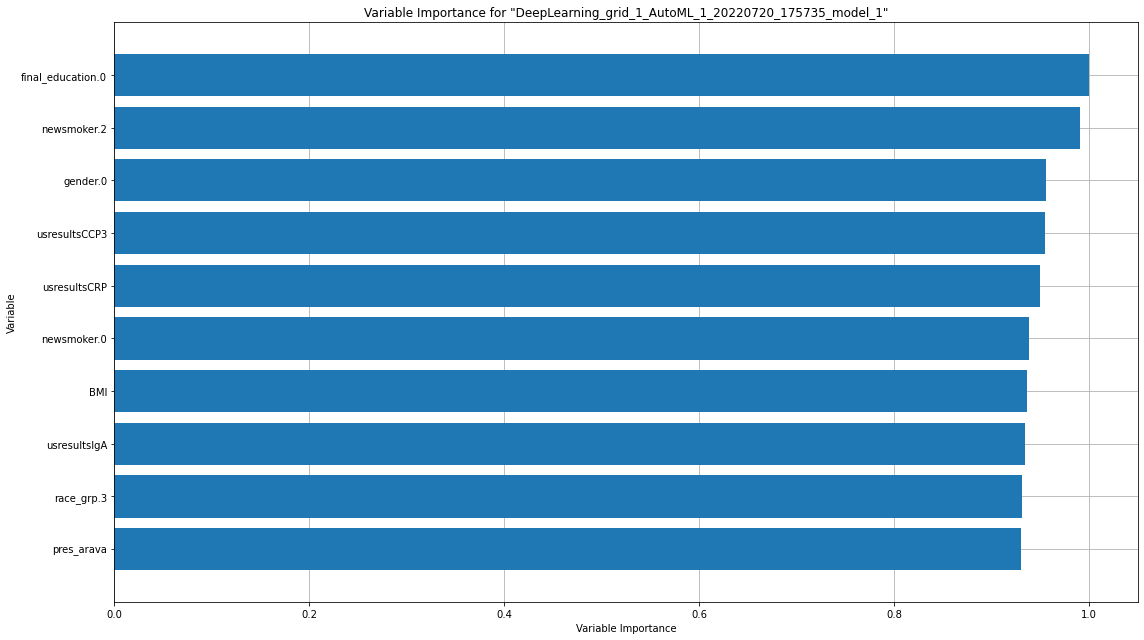

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

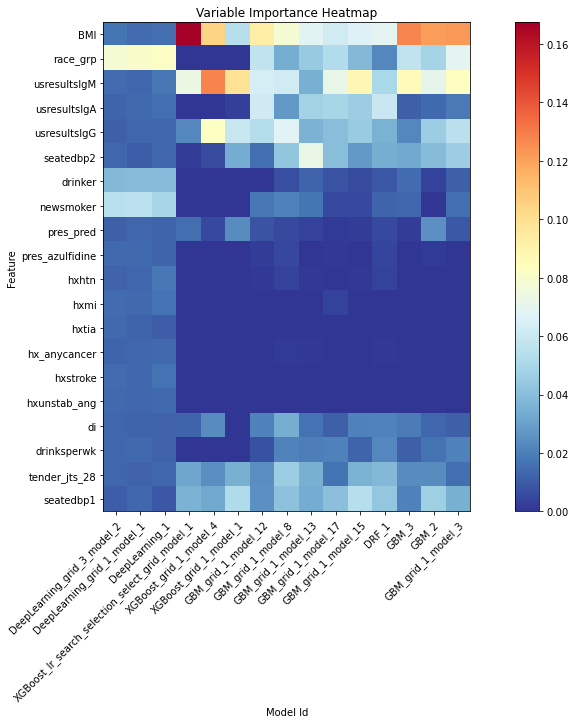

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

/Users/gaskell/miniforge_x86_64/envs/ADPred_new/lib/python3.10/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'race_grp' has levels not trained on: ["4", "5"]
  warnings.warn(w)


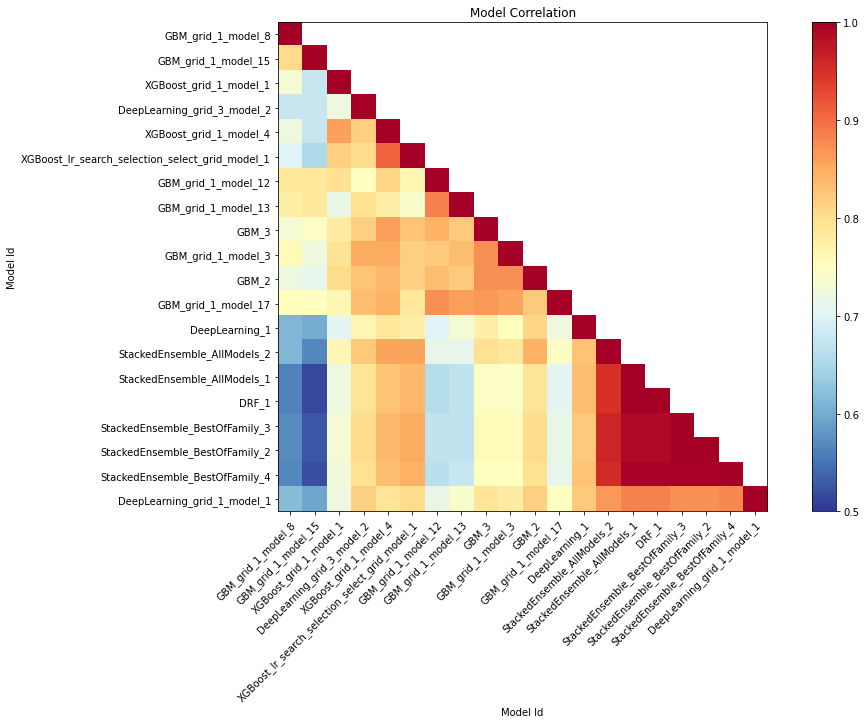

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

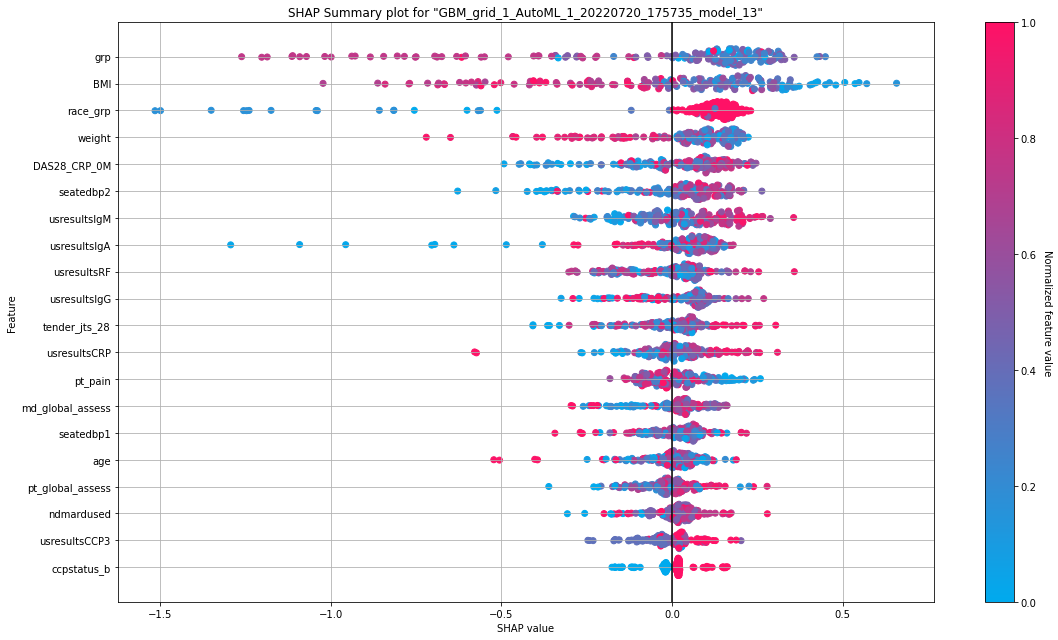

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

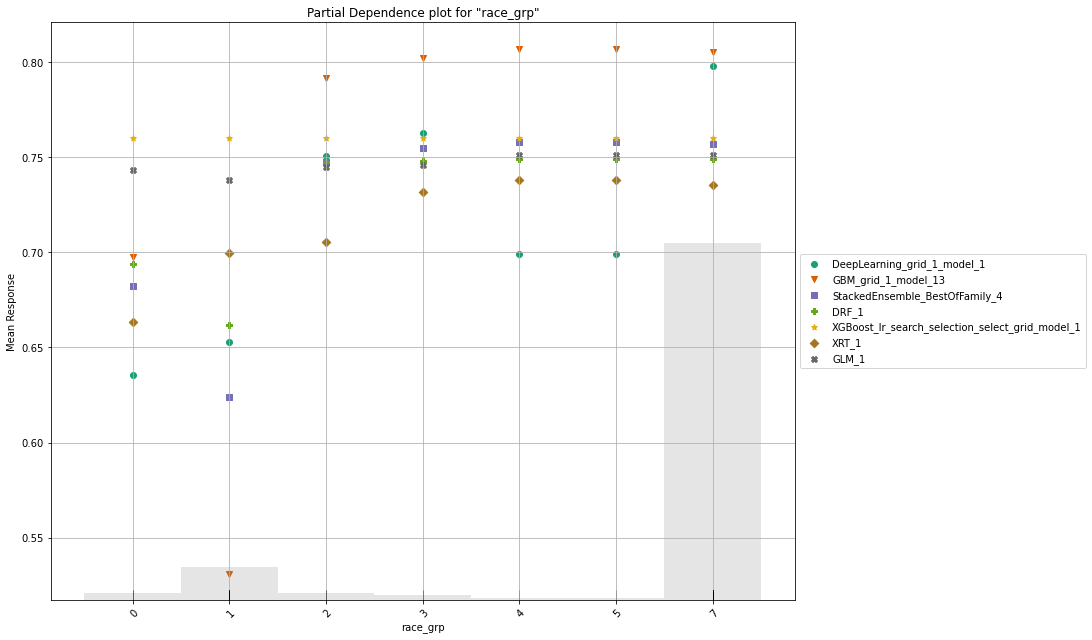

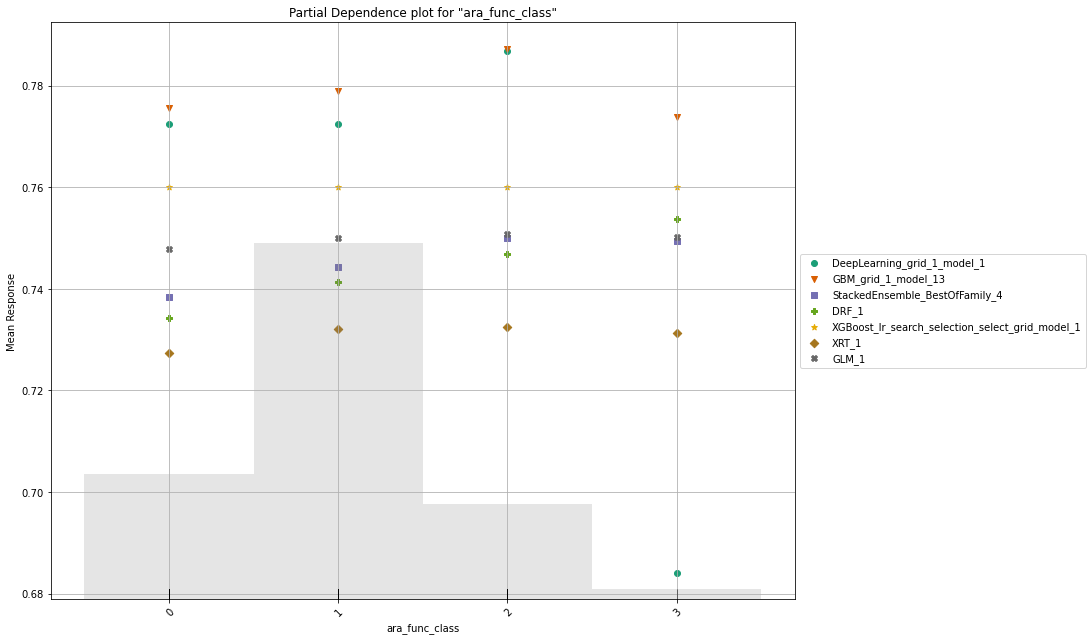

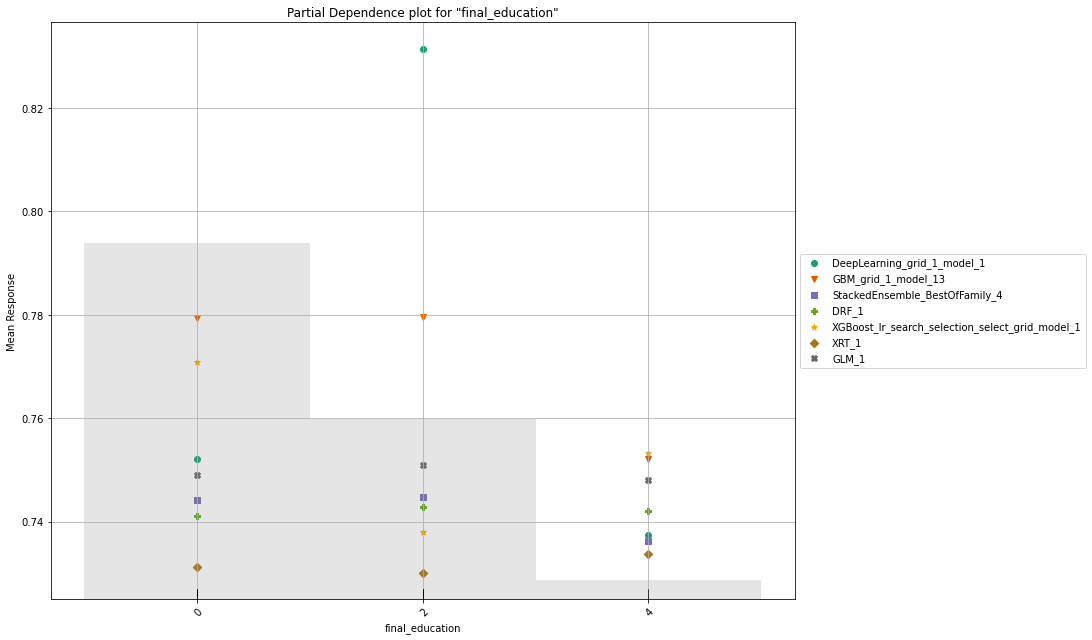

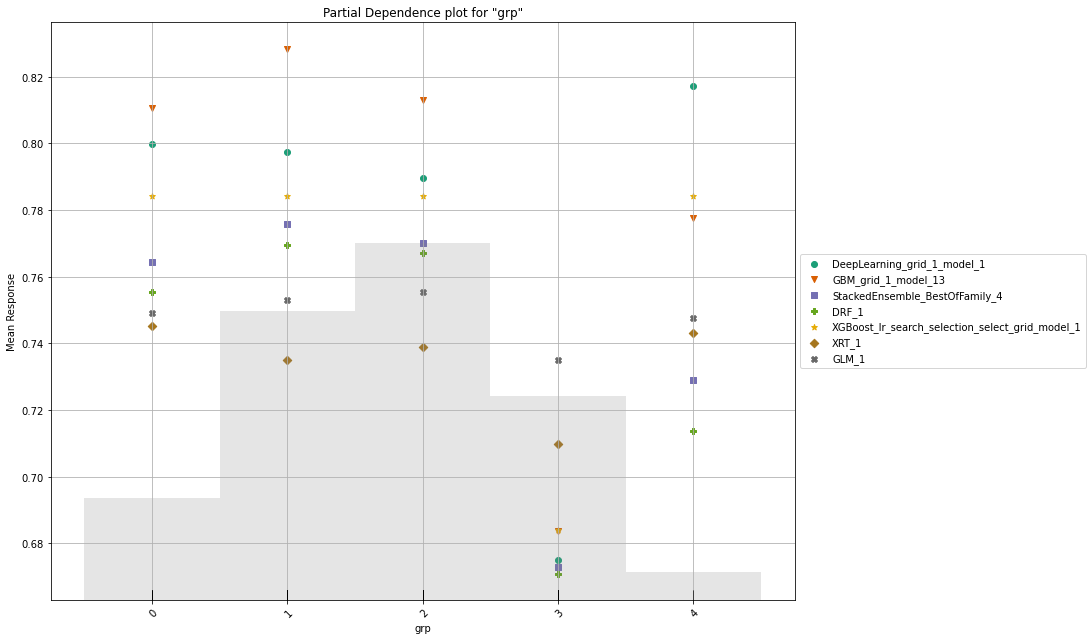

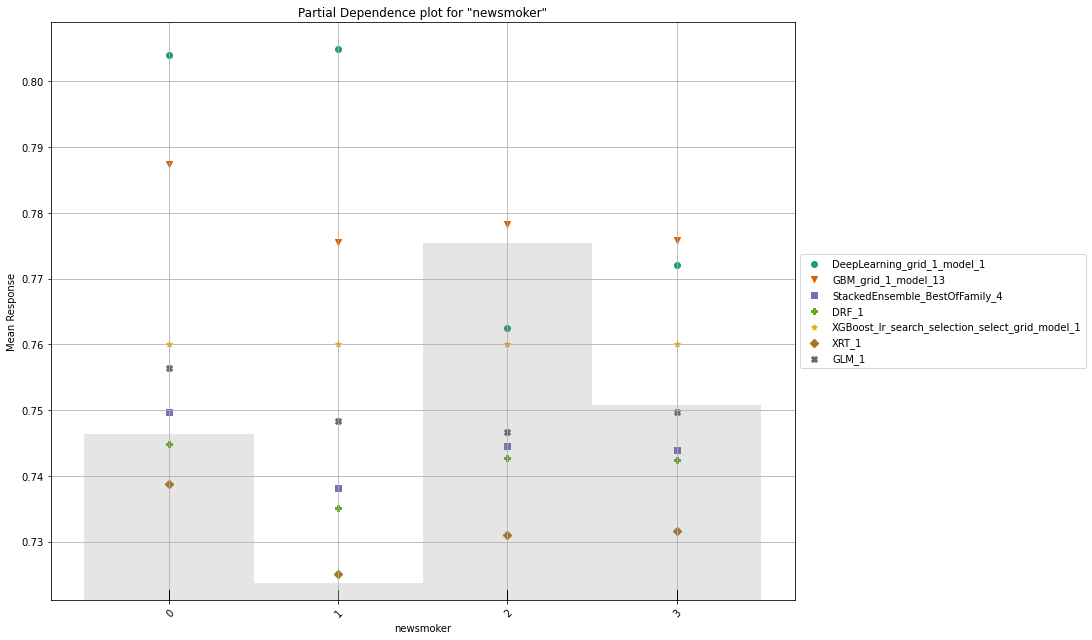

In [21]:
# Explain an AutoML object
exa = aml.explain(test_h2o)